In [58]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
import pandas as pd

In [59]:
df = pd.read_parquet("./data/DSU-Dataset.parquet")

## Basic data check

In [ ]:
df.columns

In [ ]:
df.dtypes

In [ ]:
df.head()

## Change types of columns to datetime

In [63]:
df[['Service Date', 'Recieved Date', 'Paid Date']] = df[['Service Date', 'Recieved Date', 'Paid Date']].apply(pd.to_datetime)

### Compute time difference between recieved date/ service date and paid date/ recieve date

In [64]:
df['recieve delay'] = (df['Recieved Date'] - df['Service Date']).dt.days
df['payment delay'] = (df['Paid Date'] - df['Recieved Date']).dt.days

In [ ]:
df['payment delay'].max()

In [66]:
df['Month'] = pd.to_datetime(df['Service Date']).dt.month
df['Day of Week'] = pd.to_datetime(df['Service Date']).dt.dayofweek

## Change Modifier to split them - todo

In [67]:
# df['Modifiers'] = df['Modifiers'].apply(lambda x: x.split(",") if x is not None else None)

# max_length_modifier_idx = df['Modifiers'].dropna().apply(len).idxmax()
# df.loc[max_length_modifier_idx]['Modifiers']


In [ ]:
df['Modifiers']

In [69]:
labels = df['High Cost Claim']
cols_to_drop = ['Claim ID', 'Patient ID', 'Service Date', 'Recieved Date', 'Paid Date', 'Modifiers', 'High Cost Claim']
df_short = df.drop(cols_to_drop, axis=1)

In [70]:
labels.fillna(0, inplace=True)

In [71]:
df_short = pd.get_dummies(df_short, columns=df_short.select_dtypes('object').columns)

In [72]:
df_short.rename({'Member Age_< 1 Yrs Old': 'Member Age_lessthan 1 Yrs Old'}, axis=1, inplace=True) #a feature can't have < as a character

In [ ]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(df_short, labels)

In [17]:
params = {
    "eval_metric": "aucpr",
    "eta": 0.295,  # learning rate
    "max_depth": 3,
    "max_leaves": 4,
    "lambda": 0.591,  # L2 regularization
    "alpha": 0.146,  # L1 regularization
    "gamma": 0.152,  # Minimum loss reduction required to make a further partition
    "subsample": 0.515,  # Fraction of samples used to fit trees
    "colsample_bytree": 0.656,  # Fraction of features used to fit trees
}

In [46]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(y_train, label=y_val)

In [19]:
model = XGBClassifier(params=params, verbosity=2, eval_metric='aucpr')

In [ ]:
model.fit(X_train, y_train, eval_set = [(X_val, y_val)]) 

In [ ]:
model.score(X_test, y_test)

In [22]:
imp = pd.DataFrame(data={"Features ": model.feature_names_in_, "Importances ": model.feature_importances_}) 

In [23]:
y_pred_probs = model.predict_proba(X_test)
y_preds = model.predict(X_test) 

In [ ]:
import sklearn 

sklearn.metrics.f1_score(y_test, y_preds) 

In [ ]:
y_test.value_counts()

In [ ]:
pd.Series(y_preds).value_counts()

In [ ]:
sklearn.metrics.confusion_matrix(y_test, y_preds) 

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(30, 20))
num_trees = model.get_num_boosting_rounds()
# print(num_trees)
plot_tree(model, num_trees=68, rankdir='LR', ax=ax)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 30))
xgb.plot_importance(model, ax=ax)

In [ ]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.metrics import average_precision_score


class CustomEarlyStopping(xgb.callback.TrainingCallback):
    """Stops training if the improvement is less than min_delta over early_stopping_rounds."""

    def __init__(self, early_stopping_rounds=50, min_delta=0.01):
        self.early_stopping_rounds = early_stopping_rounds
        self.min_delta = min_delta
        self.best_score = -np.inf
        self.best_iteration = 0
        self.counter = 0

    def after_iteration(self, model, epoch, evals_log):
        """Checks improvement after each round and stops if it's too small."""
        # Get latest validation score
        current_score = evals_log["valid"]["aucpr"][-1]

        # Check if improvement is greater than min_delta
        if current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.best_iteration = epoch
            self.counter = 0  # Reset counter if improvement is significant
        else:
            self.counter += 1  # Increase counter if improvement is too small

        # Stop if no significant improvement in `early_stopping_rounds`
        if self.counter >= self.early_stopping_rounds:
            print(
                f"\nEarly stopping triggered at iteration {epoch} with best score {self.best_score:.5f}"
            )
            return True  # Returning True signals XGBoost to stop training

        return False  # Continue training

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)


# Define the objective function for Optuna
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True), # learning rate
        "max_depth": trial.suggest_int("max_depth", 1, 3),
        "max_leaves": trial.suggest_int("max_leaves", 1, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True), # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True), # L1 regularization
        "gamma": trial.suggest_float("gamma", 1e-3, 5, log=True), # Minimum loss reduction required to make a further partition
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Fraction of samples used to fit trees
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0), # Fraction of features used to fit trees
    }

    # Define your callback with a minimum improvement threshold of 0.01
    custom_early_stopping = CustomEarlyStopping(early_stopping_rounds=50, min_delta=0.001)

    # Train model with early stopping
    evals = [(dtrain, "train"), (dvalid, "valid")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        verbose_eval=False,
        callbacks=[custom_early_stopping],
    )
    
    best_iter = model.best_iteration if hasattr(model, "best_iteration") else model.num_boosted_rounds()

    # Predict and evaluate using AUC-PR
    y_pred = model.predict(dvalid, iteration_range=(0, best_iter))
    aucpr = average_precision_score(y_val, y_pred)
    return aucpr


# Run optimization
study = optuna.create_study(direction="maximize", storage="sqlite:///xgboost_study.db", study_name="xgboost_study", load_if_exists=True)
study.optimize(objective, n_trials=30)

# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
study.trials_dataframe().sort_values("value", ascending=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure CustomEarlyStopping is already defined
custom_early_stopping = CustomEarlyStopping(early_stopping_rounds=50, min_delta=0.001)

# Correct the order of train_test_split return values
X_train, X_val, y_train, y_val = train_test_split(df_short, labels)

params = {
    "eval_metric": "aucpr",
    "eta": 0.295,  # learning rate
    "max_depth": 3,
    "max_leaves": 4,
    "lambda": 0.591,  # L2 regularization
    "alpha": 0.146,  # L1 regularization
    "gamma": 0.152,  # Minimum loss reduction required to make a further partition
    "subsample": 0.515,  # Fraction of samples used to fit trees
    "colsample_bytree": 0.656,  # Fraction of features used to fit trees
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtrain, "train"), (dval, "valid")], verbose_eval=10, callbacks=[custom_early_stopping])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

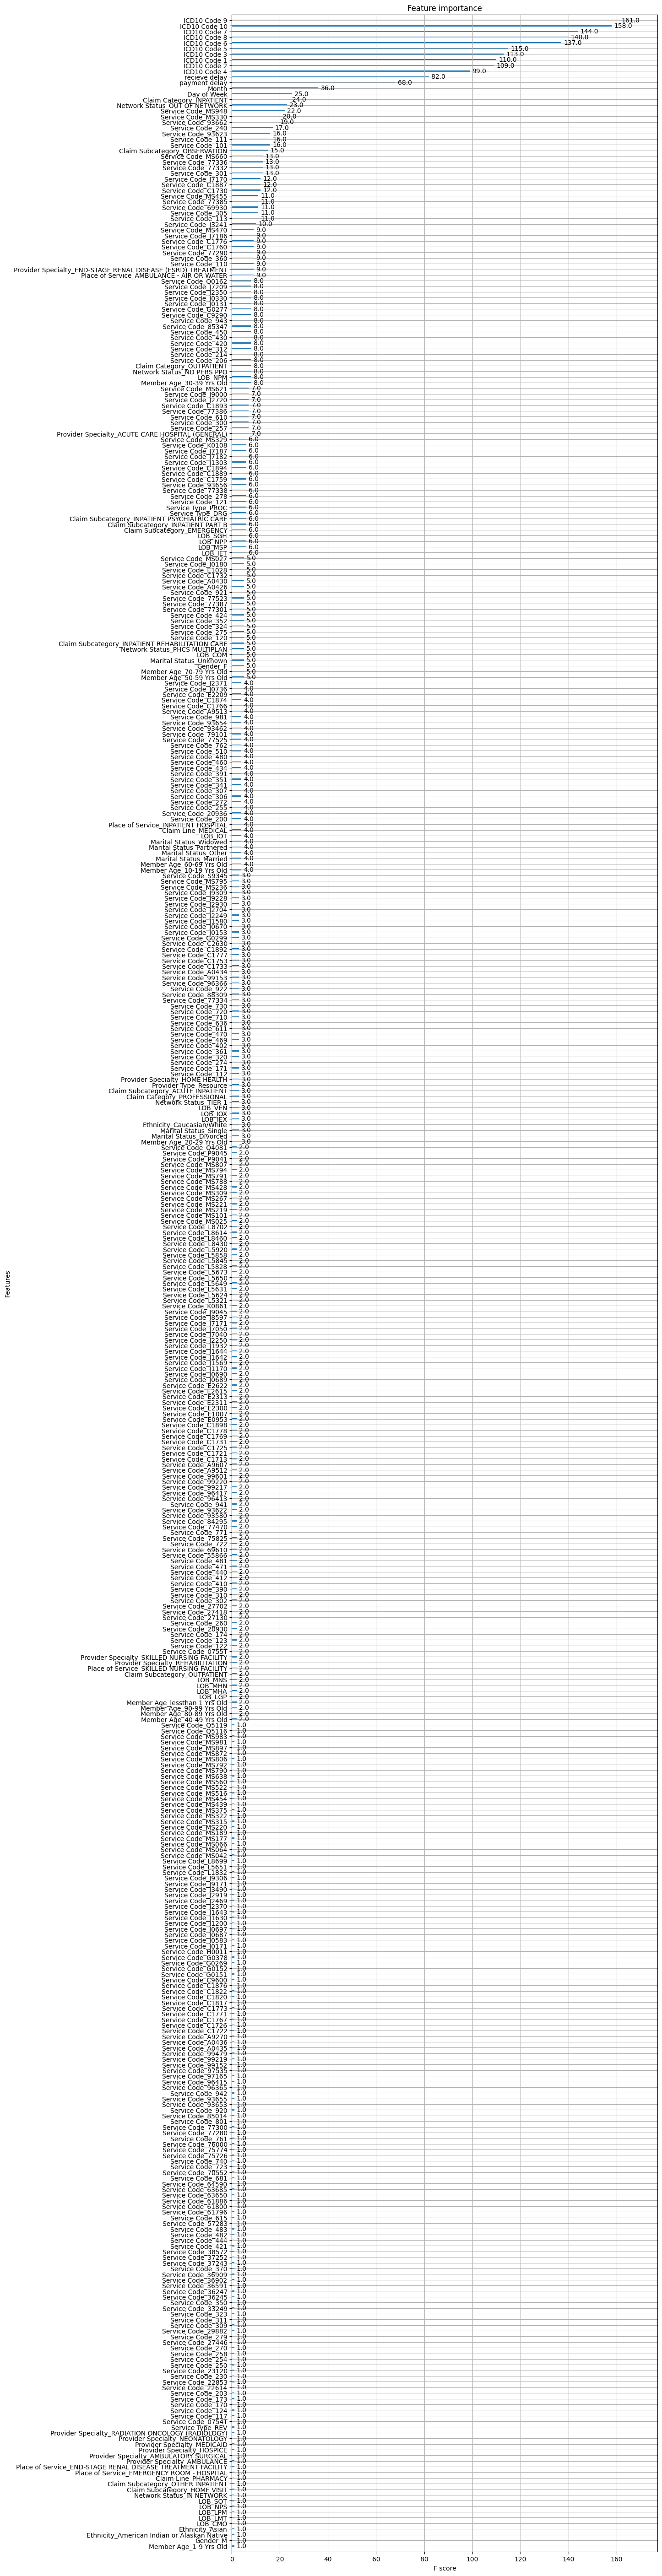

In [95]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 72))
xgb.plot_importance(model, ax=ax)